In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import telegram
import io
from read_db.CH import Getch
import datetime
import pandahouse
import os
import statistics

#### Вынимаем данные из базы SQL запросами

In [25]:
data_views=Getch("select \
toStartOfInterval(time, INTERVAL 15 minute) as t, \
count(user_id) as metric \
from simulator.feed_actions \
where toDate(time)>today()-15 and action='view' \
group by t \
order by t").df

In [26]:
data_likes=Getch("select \
toStartOfInterval(time, INTERVAL 15 minute) as t, \
count(user_id) as metric \
from simulator.feed_actions \
where toDate(time)>today()-15 and action='like' \
group by t \
order by t").df

In [27]:
data_activ_feed=Getch("select \
toStartOfInterval(time, INTERVAL 15 minute) as t, \
uniq(user_id) as metric \
from simulator.feed_actions \
where toDate(time)>today()-15 \
group by t \
order by t").df

In [28]:
data_activ_mess=Getch("select \
toStartOfInterval(time, INTERVAL 15 minute) as t, \
uniq(user_id) as metric \
from simulator.message_actions \
where toDate(time)>today()-15 \
group by t \
order by t").df

In [29]:
data_mess=Getch("select \
toStartOfInterval(time, INTERVAL 15 minute) as t, \
count(user_id) as metric \
from simulator.message_actions \
where toDate(time)>today()-15 \
group by t \
order by t").df

In [30]:
# кладем все данные в один DataFrame
data=pd.DataFrame()
data['t']=data_views['t']
data['views']=data_views['metric']
data['likes']=data_likes['metric']
data['uniq_feed']=data_activ_feed['metric']
data['uniq_mess']=data_activ_mess['metric']
data['count_mess']=data_mess['metric']
data['ctr']=round(data['likes']/data['views']*100, 2)

In [31]:
data.head()

,t,views,likes,uniq_feed,uniq_mess,count_mess,ctr
0,2021-11-27 00:00:00,6393,1321,346,64,71,20.66
1,2021-11-27 00:15:00,6231,1357,342,80,89,21.78
2,2021-11-27 00:30:00,6479,1344,349,65,70,20.74
3,2021-11-27 00:45:00,6262,1333,319,64,70,21.29
4,2021-11-27 01:00:00,5351,1136,296,63,72,21.23


#### Смотрим на характер данных и характер выбросов

<AxesSubplot:xlabel='t', ylabel='views'>

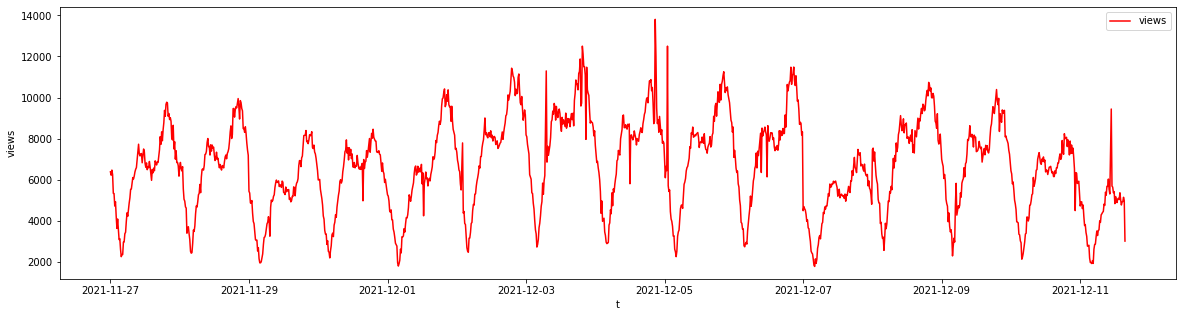

In [32]:
plt.figure(figsize=(20,5))
sns.lineplot(x='t', y='views', data=data,label='views', color='red')

<AxesSubplot:xlabel='t', ylabel='likes'>

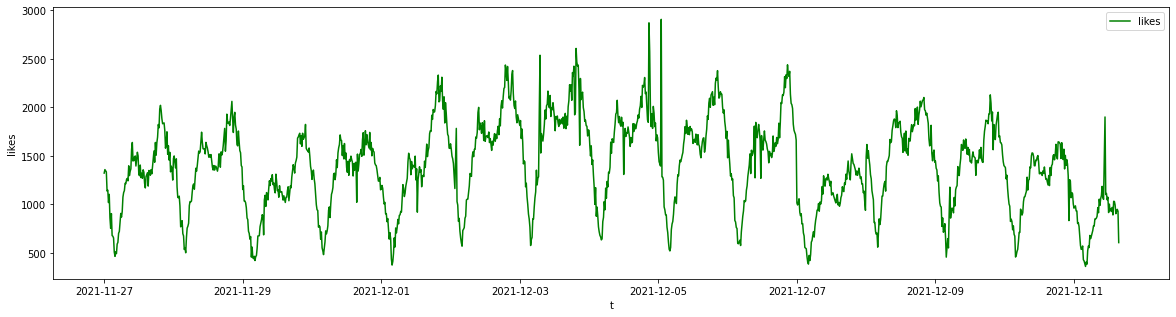

In [33]:
plt.figure(figsize=(20,5))
sns.lineplot(x='t', y='likes', data=data, label='likes', color='green')

<AxesSubplot:xlabel='t', ylabel='uniq_feed'>

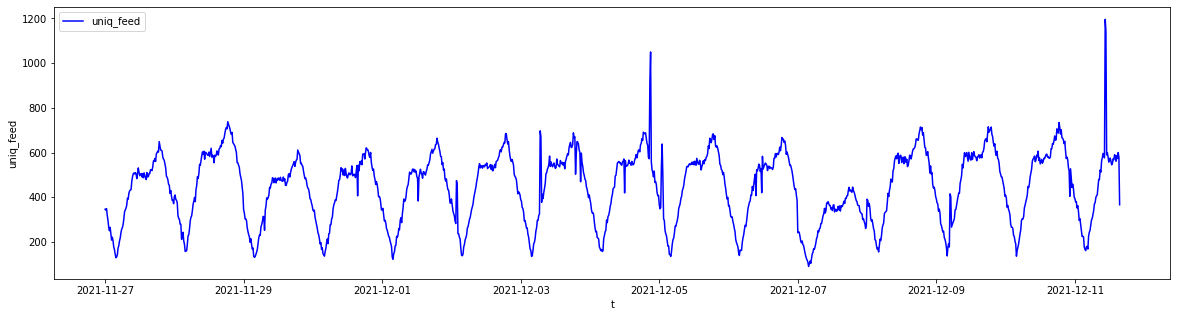

In [34]:
plt.figure(figsize=(20,5))
sns.lineplot(x='t', y='uniq_feed', data=data, label='uniq_feed', color='blue')

<AxesSubplot:xlabel='t', ylabel='uniq_mess'>

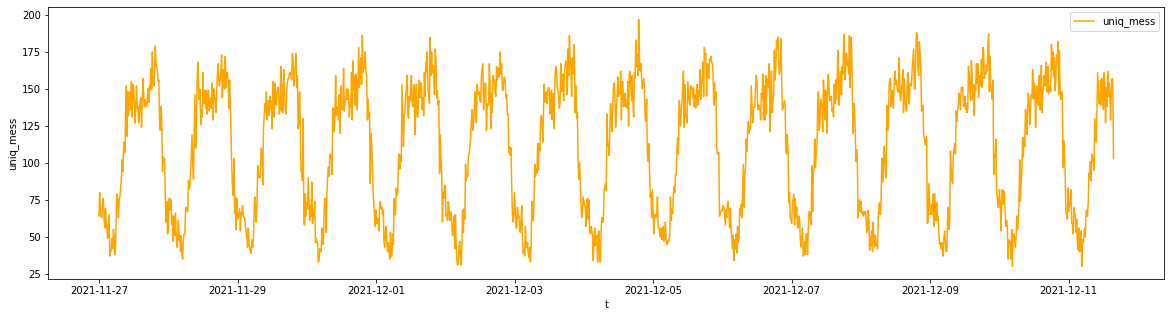

In [35]:
plt.figure(figsize=(20,5))
sns.lineplot(x='t', y='uniq_mess', data=data, label='uniq_mess', color='orange')

<AxesSubplot:xlabel='t', ylabel='count_mess'>

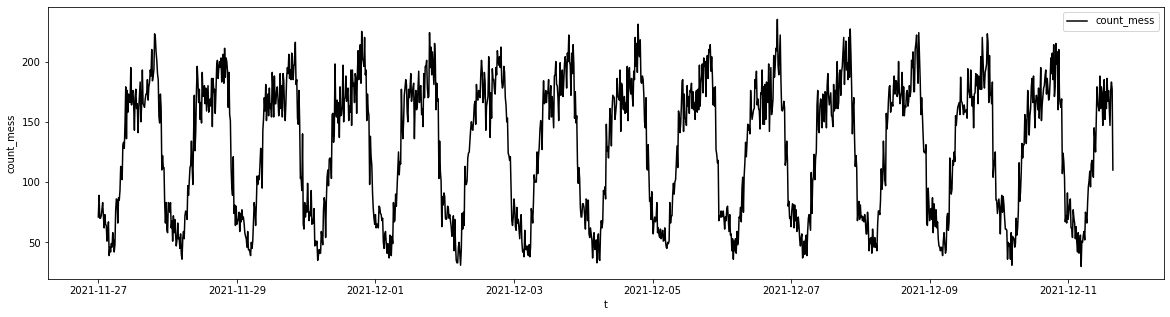

In [36]:
plt.figure(figsize=(20,5))
sns.lineplot(x='t', y='count_mess', data=data, label='count_mess', color='black')

<AxesSubplot:xlabel='t', ylabel='ctr'>

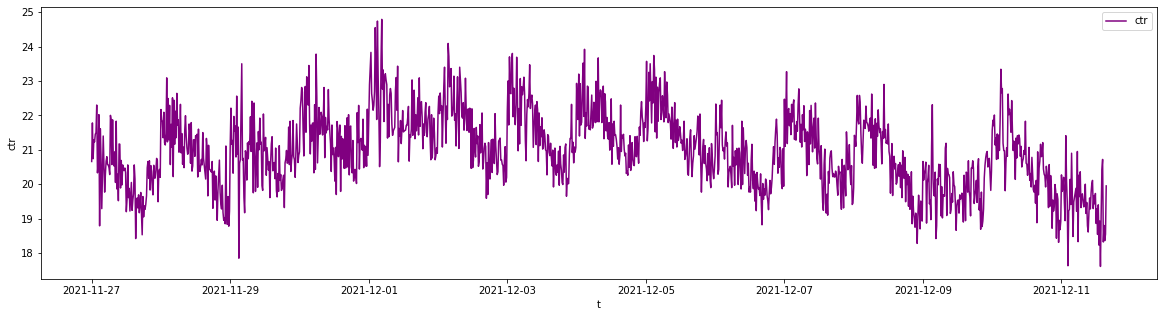

In [37]:
plt.figure(figsize=(20,5))
sns.lineplot(x='t', y='ctr', data=data, label='ctr', color='purple')

In [38]:
data.head()

,t,views,likes,uniq_feed,uniq_mess,count_mess,ctr
0,2021-11-27 00:00:00,6393,1321,346,64,71,20.66
1,2021-11-27 00:15:00,6231,1357,342,80,89,21.78
2,2021-11-27 00:30:00,6479,1344,349,65,70,20.74
3,2021-11-27 00:45:00,6262,1333,319,64,70,21.29
4,2021-11-27 01:00:00,5351,1136,296,63,72,21.23


#### Ловим выбросы

In [39]:
# собираем данные по предыдущей пятнадцатиминутке за days_ago предыдущих дней
days_ago=14
temp_date=pd.DataFrame()
data_ago=pd.DataFrame()
for i in range(1,days_ago+1):
    temp_date=data.iloc[data.shape[0]-2,0:1]-datetime.timedelta(days=i)
    data_ago=data_ago.append(data.loc[data['t'] == temp_date[0]])
data_ago

,t,views,likes,uniq_feed,uniq_mess,count_mess,ctr
1309,2021-12-10 15:15:00,6445,1296,574,152,171,20.11
1213,2021-12-09 15:15:00,7684,1561,588,132,145,20.31
1117,2021-12-08 15:15:00,8096,1652,571,140,155,20.41
1021,2021-12-07 15:15:00,5243,1068,357,156,176,20.37
925,2021-12-06 15:15:00,7444,1481,524,133,152,19.90
829,2021-12-05 15:15:00,7706,1647,563,153,176,21.37
733,2021-12-04 15:15:00,8212,1831,551,155,196,22.30
637,2021-12-03 15:15:00,8587,1784,527,145,170,20.78
541,2021-12-02 15:15:00,7830,1728,532,167,204,22.07
445,2021-12-01 15:15:00,6437,1379,515,144,166,21.42


In [ ]:
# описываем функцию вычисления доверительного интервала и скользящего среднего
def confid_int(data, alfa):        
    #вариант с сигмами
    #x_min=round(data.mean()-alfa*statistics.stdev(data))
    #x_max=round(data.mean()+alfa*statistics.stdev(data))  
    # Выбираем вариант с процентилями, потому что он позволят минимизировать влияние предыдущих выбросов
    a=1.5
    q25=data.quantile(0.25)
    q75=data.quantile(0.75)
    iqr=q75-q25
    x_min=q25-a*iqr
    x_max=q75+a*iqr
    return(x_min, x_max, round(data.median()))

In [49]:
# описываем функцию вывода графика
def send_graph (data, metric, min_conf, max_conf):
    bot=telegram.Bot(token='5040852626:AAGIuHp8MMKegdiorCUzSzABVHNYvrdNGNQ')
    chat_id=898434133
    plt.figure(figsize=(8,5))
    sns.lineplot(x='t', y=metric, data=data, label=metric, color='red')
    sns.lineplot(x='t', y=min_conf, data=data, label='cinfidence interval', color='green')
    sns.lineplot(x='t', y=max_conf, data=data, color='green')
    plot_obj=io.BytesIO()
    plt.savefig(plot_obj)
    plot_obj.name='temp_plot.png'
    # перенесем курсор в началло файла что бы весь его увидеть
    plot_obj.seek(0)
    plt.close()
    bot.sendPhoto(chat_id=chat_id, photo=plot_obj)

In [ ]:
# описываем функцию отправки алёрта в телеграмм бот
def send_alert(metric_name, time_loc, metric, deviation):
    bot=telegram.Bot(token='5040852626:AAGIuHp8MMKegdiorCUzSzABVHNYvrdNGNQ')
    chat_id=898434133
    alert_text='ACHTUNG!!!\nМетрика {} в срезе {}\n\
Текущее значение {}, отклонение  {}%'\
      .format(metric_name, time_loc,metric,deviation)
    bot.sendMessage(chat_id=chat_id, text=alert_text)

In [50]:
# описываем переменую с названиями столбцов DtaFrame data_ago
metrics=['views','likes','uniq_feed','uniq_mess','count_mess','ctr']

In [51]:
# выполняем проверку на наличие отклонений
alfa=3
for i in range(len(metrics)):
    min_conf, max_conf, mean=confid_int(data_ago[metrics[i]],alfa)
    if data.iloc[data.shape[0]-2,i+1]<min_conf or data.iloc[data.shape[0]-2,i+1]>max_conf:
        dev=round(((mean-data.iloc[data.shape[0]-2,i+1])/mean)*100)
        send_alert(metrics[i],data.iloc[data.shape[0]-2,0], data.iloc[data.shape[0]-2,i+1],dev)
        send_graph(data_ago, metrics[i], min_conf, max_conf)

## Рабочий код для .py файла 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import telegram
import io
from read_db.CH import Getch
import datetime
import pandahouse
import os
import statistics

def report(chat=None):
    # описываем бота
    bot=telegram.Bot(token='5040852626:AAGIuHp8MMKegdiorCUzSzABVHNYvrdNGNQ')
    chat_id_karpov_alert_bot=-664596965
    chat_id=chat_id_karpov_alert_bot
    #chat_id=898434133
    
    # собираем данные по 6 метрикам 15-ти минутными интервалами за 8 дней 
    data_views=Getch("select \
    toStartOfInterval(time, INTERVAL 15 minute) as t, \
    count(user_id) as metric \
    from simulator.feed_actions \
    where toDate(time)>today()-15 and action='view' \
    group by t \
    order by t").df
    data_likes=Getch("select \
    toStartOfInterval(time, INTERVAL 15 minute) as t, \
    count(user_id) as metric \
    from simulator.feed_actions \
    where toDate(time)>today()-15 and action='like' \
    group by t \
    order by t").df
    data_activ_feed=Getch("select \
    toStartOfInterval(time, INTERVAL 15 minute) as t, \
    uniq(user_id) as metric \
    from simulator.feed_actions \
    where toDate(time)>today()-15 \
    group by t \
    order by t").df
    data_activ_mess=Getch("select \
    toStartOfInterval(time, INTERVAL 15 minute) as t, \
    uniq(user_id) as metric \
    from simulator.message_actions \
    where toDate(time)>today()-15 \
    group by t \
    order by t").df
    data_mess=Getch("select \
    toStartOfInterval(time, INTERVAL 15 minute) as t, \
    count(user_id) as metric \
    from simulator.message_actions \
    where toDate(time)>today()-15 \
    group by t \
    order by t").df

    # кладем все данные в один DataFrame, добавляем CTR 
    data=pd.DataFrame()
    data['t']=data_views['t']
    data['views']=data_views['metric']
    data['likes']=data_likes['metric']
    data['uniq_feed']=data_activ_feed['metric']
    data['uniq_mess']=data_activ_mess['metric']
    data['count_mess']=data_mess['metric']
    data['ctr']=round(data['likes']/data['views']*100, 2)

    # формируем данные по ПРЕДЫДУЩЕЙ пятнадцатиминутке за days_ago предыдущих дней
    days_ago=14
    temp_date=pd.DataFrame()
    data_ago=pd.DataFrame()
    for i in range(1,days_ago+1):
        temp_date=data.iloc[data.shape[0]-2,0:1]-datetime.timedelta(days=i)
        data_ago=data_ago.append(data.loc[data['t'] == temp_date[0]])

    # описываем функцию вычисления доверительного интервала и скользящего среднего
    def confid_int(data, alfa):
        
        #вариант с сигмами
        #x_min=round(data.mean()-alfa*statistics.stdev(data))
        #x_max=round(data.mean()+alfa*statistics.stdev(data))
        
        # вариант с процентилями
        a=1.5
        q25=data.quantile(0.25)
        q75=data.quantile(0.75)
        iqr=q75-q25
        x_min=q25-a*iqr
        x_max=q75+a*iqr
        return(x_min, x_max, round(data.median()))

    # описываем переменую с названиями столбцов DtaFrame data_ago
    metrics=['views','likes','uniq_feed','uniq_mess','count_mess','ctr']

    # описываем функцию отправки алёртов
    def send_alert(metric_name, time_loc, metric, deviation):
        alert_text='ACHTUNG!!!\nМетрика {} в срезе {}\nТекущее значение {}, отклонение  {}%'\
        .format(metric_name, time_loc,metric,deviation)
        bot.sendMessage(chat_id=chat_id, text=alert_text)
        alert_text="[Посмотреть dashboard](https://superset.lab.karpov.courses/superset/dashboard/133/)"
        bot.sendMessage(chat_id=chat_id, text=alert_text, parse_mode='MarkdownV2')
        
    # описываем функцию отправки preview графика с отклонением
    def send_graph (data, metric, min_conf, max_conf):
        plt.figure(figsize=(10,5))
        sns.lineplot(x='t', y=metric, data=data, label=metric, color='red')
        sns.lineplot(x='t', y=min_conf, data=data, label='confidence interval +-1.5*iqr', color='green')
        sns.lineplot(x='t', y=max_conf, data=data, color='green')
        plot_obj=io.BytesIO()
        plt.savefig(plot_obj)
        plot_obj.name='temp_graph.png'
        # перенесем курсор в началло файла что бы весь его увидеть
        plot_obj.seek(0)
        plt.close()
        bot.sendPhoto(chat_id=chat_id, photo=plot_obj)

    # выполняем проверку на отклонения
    alfa=3
    for i in range(len(metrics)):
        min_conf, max_conf, median=confid_int(data_ago[metrics[i]],alfa)
        if data.iloc[data.shape[0]-2,i+1]<min_conf or data.iloc[data.shape[0]-2,i+1]>max_conf:
            dev=round(((data.iloc[data.shape[0]-2,i+1]-median)/median)*100)
            send_alert(metrics[i],data.iloc[data.shape[0]-2,0], data.iloc[data.shape[0]-2,i+1],dev)
            # добавляем в dataframe data_ago сегодняшнюю "порблемную" 15-ти минутку
            temp_date=data.iloc[data.shape[0]-2,0:1]
            data_ago=data_ago.append(data.loc[data['t'] == temp_date[0]])
            # отправляем график с сегодняшней "проблемной" 15-ти минуткой
            send_graph(data_ago, metrics[i], min_conf, max_conf)
            # удаляем из dataframe сегодняшнюю 15-ти минутку для корректной работы следующих проверок
            data_ago=data_ago.loc[data['t'] != temp_date[0]]
try:
    report()
except Exception as e:
    print(e)